In [158]:
import numpy as np

import astropy.units as u
import astropy.coordinates

import sunpy.map
import sunpy.coordinates


import sunkit_image.coalignment as ski
import sunpy.physics.differential_rotation as diffrot

import matplotlib.pyplot as plt


In [137]:
def calculate_solar_rotate_shift(mc, layer_index=0, **kwargs):
       
    nt = len(mc.maps)
    xshift_arcseconds = np.zeros(nt) * u.arcsec
    yshift_arcseconds = np.zeros_like(xshift_arcseconds)
    observer_coordinate_ref_layer = mc.maps[layer_index].observer_coordinate

    for i, m in enumerate(mc):
        
        # Calculate the rotation of the center of the map 'm' at its
        # observation time to the observation time of the reference layer
        # indicated by "layer_index".
        new_coordinate = diffrot.solar_rotate_coordinate(m.center, observer=observer_coordinate_ref_layer, **kwargs)

        xshift_arcseconds[i] = new_coordinate.Tx - m.center.Tx
        yshift_arcseconds[i] = new_coordinate.Ty - m.center.Ty

    # Set the shifts relative to the reference layer
    # The shift of the reference layer is always zero by definition.
    xshift_ref=xshift_arcseconds[layer_index]
    yshift_ref=yshift_arcseconds[layer_index]
    xshift_arcseconds=xshift_arcseconds-xshift_ref
    yshift_arcseconds=yshift_arcseconds-yshift_ref
            

    return {"x": xshift_arcseconds, "y": yshift_arcseconds}

In [138]:
map0 = sunpy.map.Map('aia.lev1_euv_12s.2024-01-04T190103Z.193.image.fits')
map1 = sunpy.map.Map('aia.lev1_euv_12s.2024-01-04T200103Z.193.image.fits')
map2 = sunpy.map.Map('aia.lev1_euv_12s.2024-01-04T210103Z.193.image.fits')
map3 = sunpy.map.Map('aia.lev1_euv_12s.2024-01-04T220103Z.193.image.fits')
map4 = sunpy.map.Map('aia.lev1_euv_12s.2024-01-04T230103Z.193.image.fits')
map5 = sunpy.map.Map('aia.lev1_euv_12s.2024-01-05T000103Z.193.image.fits')


In [139]:
map_seq = sunpy.map.Map([map0, map1,map2,map3,map4,map5], sequence=True) 

In [147]:
oldShift=ski.calculate_solar_rotate_shift(map_seq, layer_index=0)
oldShift

{'x': <Quantity [  6.20223105,   0.        ,  11.88622815, -30.79497721,
             11.83393375, -12.56790218] arcsec>,
 'y': <Quantity [29.69411448,  0.        , 42.30863101, 18.55723253, 48.93259702,
            19.17634018] arcsec>}

In [149]:
newShift=calculate_solar_rotate_shift(map_seq, layer_index=0)
newShift

{'x': <Quantity [  0.        ,  -6.13211901, -12.30921682, -19.30989953,
            -24.3882123 , -30.91246239] arcsec>,
 'y': <Quantity [0.        , 0.30072454, 0.61879132, 0.83742729, 1.2428831 ,
            1.4688969 ] arcsec>}

In [153]:
mapOldShift=ski.mapsequence_coalign_by_rotation(map_seq,layer_index=0,shift=oldShift)
mapNewShift=ski.mapsequence_coalign_by_rotation(map_seq,layer_index=0,shift=newShift)


In [160]:
my_map=mapNewShift[0]
roi_bottom_left = SkyCoord(Tx=630*u.arcsec, Ty=-150*u.arcsec, frame=my_map.coordinate_frame)
roi_top_right = SkyCoord(Tx=770*u.arcsec, Ty=-300*u.arcsec, frame=my_map.coordinate_frame)



<SkyCoord (Helioprojective: obstime=2024-01-04T19:01:04.843, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2024-01-04T19:01:04.843, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.00018919, -3.37382523, 1.47062e+11)>): (Tx, Ty) in arcsec
    (630., -150.)>

c:\Users\paolo\AppData\Local\Programs\Python\Python37\lib\site-packages\astropy\visualization\wcsaxes\patches.py:165: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


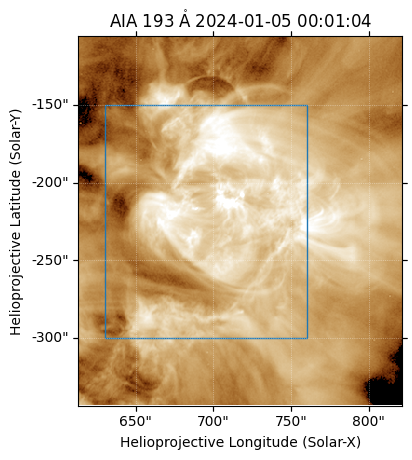

In [188]:
my_map=mapNewShift[5]
roi_bottom_left = SkyCoord(Tx=630*u.arcsec, Ty=-150*u.arcsec, frame=my_map.coordinate_frame)
roi_top_right = SkyCoord(Tx=760*u.arcsec, Ty=-300*u.arcsec, frame=my_map.coordinate_frame)

fig = plt.figure()
ax = fig.add_subplot(projection=my_map)
my_map.plot(axes=ax, clip_interval=(1,99.5)*u.percent)
my_map.draw_quadrangle(roi_bottom_left, top_right=roi_top_right, axes=ax, color='C0')
plt.show()

c:\Users\paolo\AppData\Local\Programs\Python\Python37\lib\site-packages\astropy\visualization\wcsaxes\patches.py:165: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


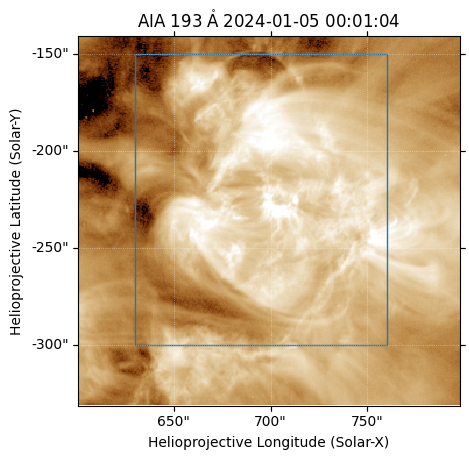

In [194]:
my_map=mapOldShift[5]
roi_bottom_left = SkyCoord(Tx=630*u.arcsec, Ty=-150*u.arcsec, frame=my_map.coordinate_frame)
roi_top_right = SkyCoord(Tx=760*u.arcsec, Ty=-300*u.arcsec, frame=my_map.coordinate_frame)

fig = plt.figure()
ax = fig.add_subplot(projection=my_map)
my_map.plot(axes=ax, clip_interval=(1,99.5)*u.percent)
my_map.draw_quadrangle(roi_bottom_left, top_right=roi_top_right, axes=ax, color='C0')
plt.show()

In [197]:
mapNewShiftCropped=[]
for m in mapNewShift:
    mapNewShiftCropped.append(m.submap(roi_bottom_left,top_right=roi_top_right))

mapOldShiftCropped=[]
for m in mapOldShift:
    mapOldShiftCropped.append(m.submap(roi_bottom_left,top_right=roi_top_right))

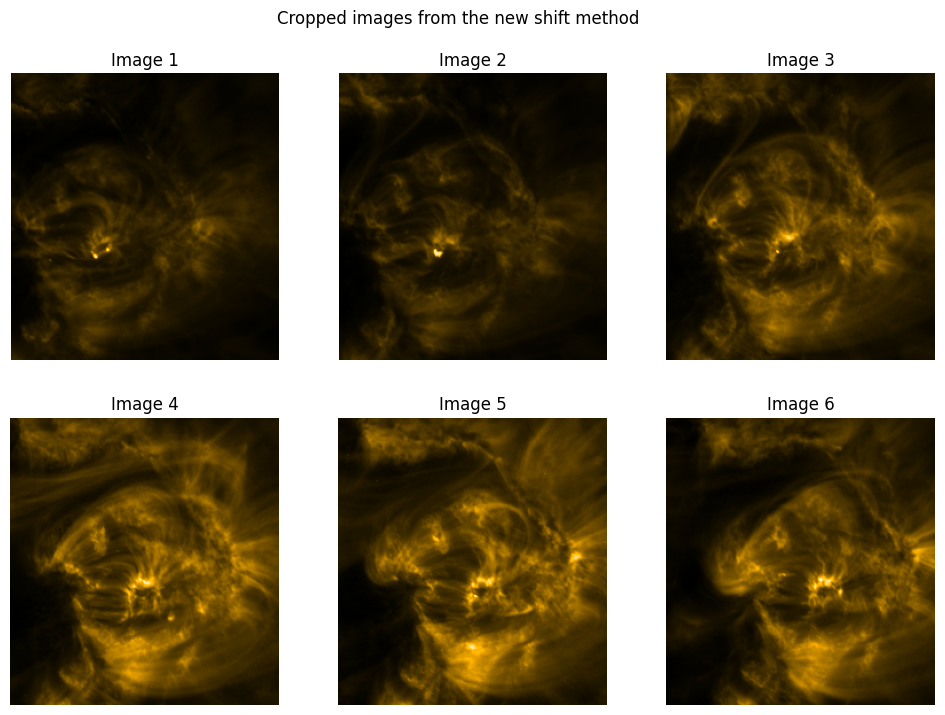

In [198]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the images and plot them on the subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(mapNewShiftCropped[i].data, cmap='sdoaia171')  # You may adjust the colormap as needed
    ax.set_title(f'Image {i+1}')  # Set titles for each subplot
    ax.axis('off')  # Turn off axis labels

# Adjust spacing between subplots
# plt.tight_layout
fig.suptitle('Cropped images from the new shift method')  # Set the title for the entire figure
fig.subplots_adjust(top=0.9)  # Adjust the spacing between the title and the subplots
# Show the plot
plt.show()

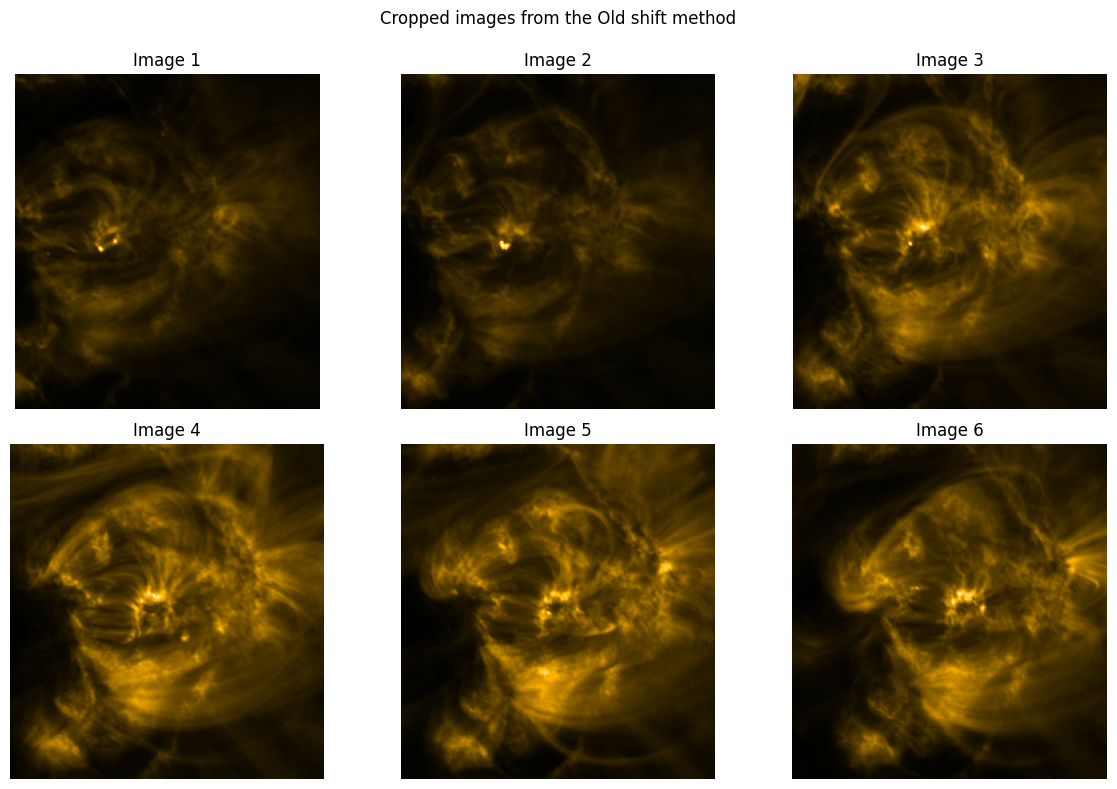

In [242]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the images and plot them on the subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(mapOldShiftCropped[i].data, cmap='sdoaia171')  # You may adjust the colormap as needed
    ax.set_title(f'Image {i+1}')  # Set titles for each subplot
    ax.axis('off')  # Turn off axis labels

# Adjust spacing between subplots
plt.tight_layout()

fig.suptitle('Cropped images from the Old shift method')  # Set the title for the entire figure
fig.subplots_adjust(top=0.9)  # Adjust the spacing between the title and the subplots

# Show the plot
plt.show()

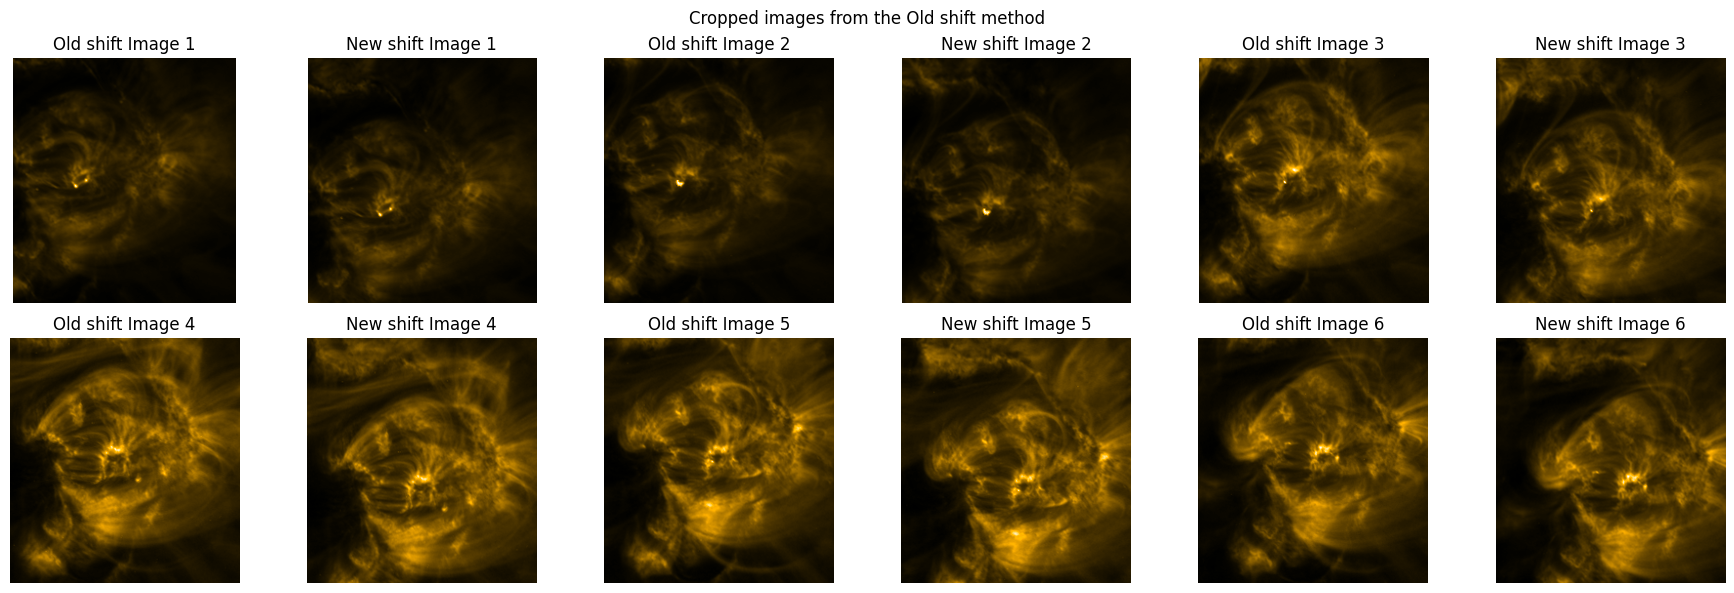

In [243]:
combinedArray=[None]*12

for i in range(6):
    combinedArray[2*i]=mapOldShiftCropped[i].data
    combinedArray[2*i+1]=mapNewShiftCropped[i].data



fig, axes = plt.subplots(2, 6, figsize=(18, 6))

# Iterate over the images and plot them on the subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(combinedArray[i], cmap='sdoaia171')  # You may adjust the colormap as needed
    if(i%2==0):
        ax.set_title(f'Old shift Image {i//2+1}')
    else:
        ax.set_title(f'New shift Image {i//2+1}')
    ax.axis('off')  # Turn off axis labels

# Adjust spacing between subplots
plt.tight_layout()

fig.suptitle('Cropped images from the Old shift method')  # Set the title for the entire figure
fig.subplots_adjust(top=0.9)  # Adjust the spacing between the title and the subplots

# Show the plot
plt.show()